<a href="https://colab.research.google.com/github/tsmanral/Author-Prediction-Using-Deep-Learning-Models/blob/master/Model_for_FFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Flatten, GlobalAveragePooling1D
from keras.layers import Embedding, TimeDistributed
import keras.utils
from keras.callbacks import ModelCheckpoint  


Using TensorFlow backend.


In [0]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data_clean')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1W_ncgu50M_LR65A4jVvCuFklmosjIfpz' in parents"}).GetList()

data = []
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  with open(fname, 'r', encoding = "ISO-8859-1") as file:
    data.append([f['title'].split('-')[0], file.read()])

title: Humphrey Ward - 14.txt, id: 1KQ8TIQFtWWWJhsp6QIpn5RGhYO7NQ3wk
downloading to /content/data_clean/Humphrey Ward - 14.txt
title: Humphrey Ward - 16.txt, id: 1Xx6zE79WHWVFowU477l1YPGYMnEd4uCn
downloading to /content/data_clean/Humphrey Ward - 16.txt
title: Humphrey Ward - 19.txt, id: 1T9QE_hSZUx17oa7QGekYM23SIgLSfsE4
downloading to /content/data_clean/Humphrey Ward - 19.txt
title: Humphrey Ward - 17.txt, id: 1xx-umzzZFNncv9X8OWWj4auY60ShAE-8
downloading to /content/data_clean/Humphrey Ward - 17.txt
title: Humphrey Ward - 15.txt, id: 1CsLYGbi6pirecPBPNwli90Sb-XSM8q33
downloading to /content/data_clean/Humphrey Ward - 15.txt
title: Humphrey Ward - 18.txt, id: 1EULi5tNbF07SbrhycdDj_u58MVe8te2N
downloading to /content/data_clean/Humphrey Ward - 18.txt
title: Humphrey Ward - 13.txt, id: 15za4_hyAnLyw9xALmmp3R54m-ZfGtnjv
downloading to /content/data_clean/Humphrey Ward - 13.txt
title: Humphrey Ward - 9.txt, id: 1ZwNeiFvLOHUXsAJHUvC2PIJupsxT89Ne
downloading to /content/data_clean/Humphrey

title: Henry Rider Haggard - 2.txt, id: 182DLelFZVUwgVCXgMYqyljcdeVekKLyg
downloading to /content/data_clean/Henry Rider Haggard - 2.txt
title: Henry Rider Haggard - 4.txt, id: 1RW0VikO9suP-fdX6U9WlmPnC47Pw_gTV
downloading to /content/data_clean/Henry Rider Haggard - 4.txt
title: Gilbert Parker - 14.txt, id: 1PtwJLsc_phb72-juruLNQWBWJgzbY2gk
downloading to /content/data_clean/Gilbert Parker - 14.txt
title: Henry Rider Haggard - 6.txt, id: 103UEqkdS8kQsRH9WWQqY2I3jM0pwHRj1
downloading to /content/data_clean/Henry Rider Haggard - 6.txt
title: Henry Rider Haggard - 1.txt, id: 1kxRrRkIluKMT-OZLdo6vqoWiUcGX23qN
downloading to /content/data_clean/Henry Rider Haggard - 1.txt
title: Gilbert Parker - 16.txt, id: 17na4xSvHKXD5OmCeJYiHVyf3YWnONGNs
downloading to /content/data_clean/Gilbert Parker - 16.txt
title: Henry Rider Haggard - 3.txt, id: 10P8MfJtE9KcHf9DwutglKBuSFVbi3GTx
downloading to /content/data_clean/Henry Rider Haggard - 3.txt
title: Gilbert Parker - 15.txt, id: 1RsBp3uXa_WruUJeYPAP0

title: George Gissing - 2.txt, id: 1TgeehcW7iqntOfbRLH8iy1I15XBVdaxj
downloading to /content/data_clean/George Gissing - 2.txt
title: George Gissing - 1.txt, id: 1KDkLX5NHiTSltmuM62AjHLvysn9YIOsr
downloading to /content/data_clean/George Gissing - 1.txt
title: Arthur Conan Doyle - 16.txt, id: 1x7aFEQd4B22hXRhgcXtFqpFynrELXh_1
downloading to /content/data_clean/Arthur Conan Doyle - 16.txt
title: Arthur Conan Doyle - 11.txt, id: 1r5sFr40dIr6fRkcxLSKnGFGAAAA6S5pT
downloading to /content/data_clean/Arthur Conan Doyle - 11.txt
title: Arthur Conan Doyle - 14.txt, id: 1Il1phCs0DRuvcGPWCeTBZxBhyrzuNvJd
downloading to /content/data_clean/Arthur Conan Doyle - 14.txt
title: Arthur Conan Doyle - 17.txt, id: 1WO8c4eGI0PrkbgPKuycecVefuVn8PRfK
downloading to /content/data_clean/Arthur Conan Doyle - 17.txt
title: Arthur Conan Doyle - 13.txt, id: 1FePgEn_ZEgdeqWtdJyI5PNR8RXAlSCas
downloading to /content/data_clean/Arthur Conan Doyle - 13.txt
title: Arthur Conan Doyle - 12.txt, id: 1BU0YcOr-_2EbjkxSrPuw

In [0]:
print(len(data))

98


In [0]:
X = []
for _,c in data:
    X.append(c.lower())
    
Y = []
for i,_ in data:
    Y.append(i.lower())

X1 = []
Y_data1 = []

for text in X:
  c = text.strip().split()
  X1.append(c)

print(len(X))
X_data1 = []
count = 0
for i in X1:
  m=0
  n=1000
  times = len(i)//1000
  for j in range(times):
    X_data1.append(i[m:n])
    m = m + 1000
    n = n + 1000
    Y_data1.append(Y[count]) 
  X_data1.append(i[m:len(i)+1])
  Y_data1.append(Y[count])
  count = count + 1 



98


In [0]:
temp_list = []
for i in range(len(X_data1)):
  temp_list.append([X_data1[i], Y_data1[i]])
print(len(temp_list))
print(temp_list[0][1])

import random

random.shuffle(temp_list)
print(len(temp_list))
print(temp_list[0][1])

X_data = []
Y_data = []
for i in range(len(temp_list)):
  X_data.append(temp_list[i][0])
  Y_data.append(temp_list[i][1])
print(len(X_data), len(Y_data))
print(X_data[0], Y_data[0])

10078
humphrey ward 
10078
humphrey ward 
10078 10078
['rich', 'they', 'were', 'just', 'common', 'wheelwrights', 'you', 'understand', 'down', 'on', 't', 'whinthorpe', 'road', 'but', 'my', 'word', 'mr', 'helbeck', 'spoilt', 'their', 'game', 'for', 'em', 'he', 'lifted', 'another', 'sod', 'of', 'turf', 'from', 'the', 'basket', 'and', 'flung', 'it', 'on', 'the', 'fire', 'the', 'animus', 'of', 'his', 'tone', 'and', 'manner', 'struck', 'laura', 'oddly', 'but', 'she', 'was', 'at', 'least', 'as', 'curious', 'to', 'hear', 'as', 'he', 'was', 'anxious', 'to', 'tell', 'she', 'drew', 'her', 'chair', 'a', 'little', 'nearer', 'to', 'him', 'what', 'did', 'mr', 'helbeck', 'do', 'mason', 'laughed', 'well', 'he', 'just', 'made', 'a', 'papist', 'of', 'teddytook', 'him', 'an', 'done', 'himbrown', 'he', 'got', 'hold', 'on', 'him', 'in', 'the', 'park', 'one', 'eveningteddy', 'was', 'drawing', 'a', 'picture', 'of', 'the', 'bridge', 'you', 'understandticed', 'him', 'up', 'to', 'his', 'place', 'soomhowan', 'ted

In [0]:
print(X_data[0][:50])

['rich', 'they', 'were', 'just', 'common', 'wheelwrights', 'you', 'understand', 'down', 'on', 't', 'whinthorpe', 'road', 'but', 'my', 'word', 'mr', 'helbeck', 'spoilt', 'their', 'game', 'for', 'em', 'he', 'lifted', 'another', 'sod', 'of', 'turf', 'from', 'the', 'basket', 'and', 'flung', 'it', 'on', 'the', 'fire', 'the', 'animus', 'of', 'his', 'tone', 'and', 'manner', 'struck', 'laura', 'oddly', 'but', 'she']


In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Converting Output values to One Hot Vector
print("Converting to One hot vector(training set)...")
Y_data = np.array(Y_data)

label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(Y_data)
print(train_integer_encoded)
print(len(train_integer_encoded))

Converting to One hot vector(training set)...
[4 0 1 ... 1 0 4]
10078


In [0]:
train_onehot_encoded = keras.utils.to_categorical(train_integer_encoded)
print(train_onehot_encoded[2841,:])

[0. 0. 0. 1. 0.]


In [0]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
print(vocab_size)

128625


In [0]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_data)
print(encoded_docs[0])

[767, 35, 39, 145, 640, 37749, 13, 308, 85, 27, 3201, 10819, 422, 21, 28, 251, 130, 1615, 4621, 61, 1066, 18, 2021, 8, 792, 199, 23664, 3, 6235, 32, 1, 3525, 2, 1664, 11, 27, 1, 331, 1, 23665, 3, 14, 506, 2, 557, 497, 926, 6734, 21, 15, 9, 20, 354, 19, 954, 4, 287, 19, 8, 9, 1009, 4, 148, 15, 343, 12, 442, 5, 68, 1188, 4, 23, 43, 70, 130, 1615, 57, 3861, 424, 75, 8, 145, 96, 5, 15650, 3, 57481, 23, 47, 173, 57482, 8, 226, 406, 27, 23, 7, 1, 1511, 42, 57483, 9, 1144, 5, 957, 3, 1, 1363, 13, 57484, 23, 62, 4, 14, 195, 57485, 17954, 9, 271, 4, 5, 1899, 3, 44245, 62, 20, 1, 2233, 78, 13, 55, 113, 3148, 16438, 47, 7, 693, 573, 5050, 1220, 11, 209, 2021, 17954, 709, 91, 4, 1227, 38, 63, 2, 42, 178, 8, 2, 14, 165, 16, 207, 1, 15217, 60, 44246, 23, 5, 17955, 2, 17954, 145, 595, 2, 652, 321, 184, 35, 185, 8, 9, 20, 5, 15650, 1227, 1446, 97, 12106, 115, 47, 8, 433, 251, 4, 14, 30573, 9, 37750, 50, 13, 57486, 769, 267, 57487, 2195, 232, 4, 25, 5, 783, 47, 46, 35, 407, 77, 11, 35, 111, 145, 57, 1,

In [0]:
# pad documents to a max length of 10000 words
max_length = 1000
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[  767    35    39 ...  4337    18     1]
 [   13   185   261 ...  1389     2    50]
 [   10    40     9 ...   645     9  5403]
 ...
 [ 3612    21    14 ...   153    46    11]
 [39395  5486     2 ...     5  7994  2481]
 [    1   118     9 ...   422   386    36]]


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1ogZLyJ5GTI8a0o8HPac8zTtm96SzCv-k' in parents"}).GetList()
print(file_list[0]['title'], file_list[0]['id'] )
fname = os.path.join(local_download_path, file_list[0]['title'])
f_ = drive.CreateFile({'id': file_list[0]['id']})
f_.GetContentFile(fname)


# load the whole embedding into memory
embeddings_index = dict()
f = open(fname)
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

glove.6B.100d.txt 17BmrNJa4oJDNg3KZ6u2Ww0ETQYklOJJ7
Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(128625, 100)


In [0]:
print(padded_docs.shape)
doc_train = np.array(padded_docs[0:8000,:])
print(doc_train.shape)
doc_test = np.array(padded_docs[8000:,:])
print(doc_test.shape)

onehot_train = np.array(train_onehot_encoded[0:8000,:])
print(onehot_train.shape)
onehot_test = np.array(train_onehot_encoded[8000:,:])
print(onehot_test.shape)

(10078, 1000)
(8000, 1000)
(2078, 1000)
(8000, 5)
(2078, 5)


In [0]:


# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1000, trainable=False)
model.add(e)
model.add(GlobalAveragePooling1D())


#model.add(Dropout(0.5))

model.add(Dense(500, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.8))
model.add(Dense(1000, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.7))


model.add(Dense(5, activation='softmax'))


In [0]:
# compile the model
#from keras.optimizers import SGD
num_of_epochs = 500
batchsize = 2000
#learning_rate = 0.01

#momentum = 0.8
#sgd = SGD(lr=learning_rate, nesterov=False) #  momentum=momentum,
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 100)         12862500  
_________________________________________________________________
global_average_pooling1d_5 ( (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               50500     
_________________________________________________________________
dropout_9 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              501000    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 5005      
Total para

In [0]:
checkpointer = ModelCheckpoint(filepath='/content/weights.best.FFN.hdf5', 
                               verbose=1, save_best_only=True)

In [0]:
# fit the model
history = model.fit(doc_train, onehot_train, epochs=num_of_epochs, verbose=1, batch_size=batchsize, validation_split=0.2, callbacks=[checkpointer])

Train on 6400 samples, validate on 1600 samples
Epoch 1/500
6400/6400 [==============================] - 1s 83us/step - loss: 1.7875 - categorical_accuracy: 0.2302 - val_loss: 1.5671 - val_categorical_accuracy: 0.2625

Epoch 00001: val_loss improved from inf to 1.56712, saving model to /content/weights.best.FFN.hdf5
Epoch 2/500
6400/6400 [==============================] - 0s 36us/step - loss: 1.5940 - categorical_accuracy: 0.2559 - val_loss: 1.5546 - val_categorical_accuracy: 0.3156

Epoch 00002: val_loss improved from 1.56712 to 1.55461, saving model to /content/weights.best.FFN.hdf5
Epoch 3/500
6400/6400 [==============================] - 0s 34us/step - loss: 1.5762 - categorical_accuracy: 0.2756 - val_loss: 1.5371 - val_categorical_accuracy: 0.3288

Epoch 00003: val_loss improved from 1.55461 to 1.53713, saving model to /content/weights.best.FFN.hdf5
Epoch 4/500
6400/6400 [==============================] - 0s 33us/step - loss: 1.5545 - categorical_accuracy: 0.3042 - val_loss: 1.5327

6400/6400 [==============================] - 0s 30us/step - loss: 1.4088 - categorical_accuracy: 0.3862 - val_loss: 1.2844 - val_categorical_accuracy: 0.5312

Epoch 00012: val_loss improved from 1.35268 to 1.28439, saving model to /content/weights.best.FFN.hdf5
Epoch 13/500
6400/6400 [==============================] - 0s 29us/step - loss: 1.3258 - categorical_accuracy: 0.4781 - val_loss: 1.3485 - val_categorical_accuracy: 0.4481

Epoch 00013: val_loss did not improve
Epoch 14/500
6400/6400 [==============================] - 0s 30us/step - loss: 1.4098 - categorical_accuracy: 0.3911 - val_loss: 1.2503 - val_categorical_accuracy: 0.5169

Epoch 00014: val_loss improved from 1.28439 to 1.25026, saving model to /content/weights.best.FFN.hdf5
Epoch 15/500
6400/6400 [==============================] - 0s 31us/step - loss: 1.2988 - categorical_accuracy: 0.4797 - val_loss: 1.2313 - val_categorical_accuracy: 0.5769

Epoch 00015: val_loss improved from 1.25026 to 1.23130, saving model to /content/

6400/6400 [==============================] - 0s 30us/step - loss: 1.2217 - categorical_accuracy: 0.5041 - val_loss: 1.0299 - val_categorical_accuracy: 0.6331

Epoch 00025: val_loss improved from 1.07284 to 1.02985, saving model to /content/weights.best.FFN.hdf5
Epoch 26/500
6400/6400 [==============================] - 0s 29us/step - loss: 1.1598 - categorical_accuracy: 0.5522 - val_loss: 1.1861 - val_categorical_accuracy: 0.4900

Epoch 00026: val_loss did not improve
Epoch 27/500
6400/6400 [==============================] - 0s 30us/step - loss: 1.1671 - categorical_accuracy: 0.5242 - val_loss: 0.9879 - val_categorical_accuracy: 0.6031

Epoch 00027: val_loss improved from 1.02985 to 0.98793, saving model to /content/weights.best.FFN.hdf5
Epoch 28/500
6400/6400 [==============================] - 0s 29us/step - loss: 1.1053 - categorical_accuracy: 0.5622 - val_loss: 1.0507 - val_categorical_accuracy: 0.6200

Epoch 00028: val_loss did not improve
Epoch 29/500
6400/6400 [===================

6400/6400 [==============================] - 0s 30us/step - loss: 1.0085 - categorical_accuracy: 0.6123 - val_loss: 0.9152 - val_categorical_accuracy: 0.6206

Epoch 00038: val_loss improved from 0.92833 to 0.91522, saving model to /content/weights.best.FFN.hdf5
Epoch 39/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.9916 - categorical_accuracy: 0.6148 - val_loss: 0.9286 - val_categorical_accuracy: 0.6062

Epoch 00039: val_loss did not improve
Epoch 40/500
6400/6400 [==============================] - 0s 28us/step - loss: 1.0626 - categorical_accuracy: 0.5661 - val_loss: 0.9177 - val_categorical_accuracy: 0.6488

Epoch 00040: val_loss did not improve
Epoch 41/500
6400/6400 [==============================] - 0s 31us/step - loss: 1.0781 - categorical_accuracy: 0.5844 - val_loss: 1.2724 - val_categorical_accuracy: 0.4656

Epoch 00041: val_loss did not improve
Epoch 42/500
6400/6400 [==============================] - 0s 29us/step - loss: 1.1292 - categorical_accuracy

6400/6400 [==============================] - 0s 28us/step - loss: 0.9805 - categorical_accuracy: 0.6231 - val_loss: 0.9712 - val_categorical_accuracy: 0.6256

Epoch 00052: val_loss did not improve
Epoch 53/500
6400/6400 [==============================] - 0s 29us/step - loss: 1.0470 - categorical_accuracy: 0.5848 - val_loss: 0.8427 - val_categorical_accuracy: 0.6731

Epoch 00053: val_loss did not improve
Epoch 54/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.9286 - categorical_accuracy: 0.6464 - val_loss: 0.8525 - val_categorical_accuracy: 0.6575

Epoch 00054: val_loss did not improve
Epoch 55/500
6400/6400 [==============================] - 0s 28us/step - loss: 0.9597 - categorical_accuracy: 0.6275 - val_loss: 0.8318 - val_categorical_accuracy: 0.6913

Epoch 00055: val_loss improved from 0.84110 to 0.83182, saving model to /content/weights.best.FFN.hdf5
Epoch 56/500
6400/6400 [==============================] - 0s 29us/step - loss: 1.0008 - categorical_accuracy

6400/6400 [==============================] - 0s 31us/step - loss: 0.8631 - categorical_accuracy: 0.6739 - val_loss: 0.7819 - val_categorical_accuracy: 0.7075

Epoch 00066: val_loss did not improve
Epoch 67/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.9625 - categorical_accuracy: 0.6238 - val_loss: 0.7552 - val_categorical_accuracy: 0.7075

Epoch 00067: val_loss improved from 0.76515 to 0.75518, saving model to /content/weights.best.FFN.hdf5
Epoch 68/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.9071 - categorical_accuracy: 0.6484 - val_loss: 0.9579 - val_categorical_accuracy: 0.6319

Epoch 00068: val_loss did not improve
Epoch 69/500
6400/6400 [==============================] - 0s 33us/step - loss: 1.0037 - categorical_accuracy: 0.6134 - val_loss: 0.7541 - val_categorical_accuracy: 0.7231

Epoch 00069: val_loss improved from 0.75518 to 0.75413, saving model to /content/weights.best.FFN.hdf5
Epoch 70/500
6400/6400 [===================


Epoch 00079: val_loss did not improve
Epoch 80/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.9203 - categorical_accuracy: 0.6462 - val_loss: 0.7697 - val_categorical_accuracy: 0.7287

Epoch 00080: val_loss did not improve
Epoch 81/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.8559 - categorical_accuracy: 0.6808 - val_loss: 0.7694 - val_categorical_accuracy: 0.7169

Epoch 00081: val_loss did not improve
Epoch 82/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.8985 - categorical_accuracy: 0.6580 - val_loss: 0.7766 - val_categorical_accuracy: 0.6981

Epoch 00082: val_loss did not improve
Epoch 83/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.9023 - categorical_accuracy: 0.6406 - val_loss: 0.7921 - val_categorical_accuracy: 0.7019

Epoch 00083: val_loss did not improve
Epoch 84/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.9363 - categorical_accuracy: 0.6347 - va

6400/6400 [==============================] - 0s 29us/step - loss: 0.8592 - categorical_accuracy: 0.6623 - val_loss: 0.6950 - val_categorical_accuracy: 0.7344

Epoch 00094: val_loss improved from 0.69726 to 0.69496, saving model to /content/weights.best.FFN.hdf5
Epoch 95/500
6400/6400 [==============================] - 0s 31us/step - loss: 0.7883 - categorical_accuracy: 0.7058 - val_loss: 0.8404 - val_categorical_accuracy: 0.6812

Epoch 00095: val_loss did not improve
Epoch 96/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.9503 - categorical_accuracy: 0.6394 - val_loss: 0.6923 - val_categorical_accuracy: 0.7569

Epoch 00096: val_loss improved from 0.69496 to 0.69229, saving model to /content/weights.best.FFN.hdf5
Epoch 97/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.8097 - categorical_accuracy: 0.6973 - val_loss: 0.7144 - val_categorical_accuracy: 0.7350

Epoch 00097: val_loss did not improve
Epoch 98/500
6400/6400 [===================

6400/6400 [==============================] - 0s 32us/step - loss: 0.8486 - categorical_accuracy: 0.6802 - val_loss: 0.6863 - val_categorical_accuracy: 0.7575

Epoch 00108: val_loss did not improve
Epoch 109/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.8524 - categorical_accuracy: 0.6898 - val_loss: 0.6743 - val_categorical_accuracy: 0.7594

Epoch 00109: val_loss did not improve
Epoch 110/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.7686 - categorical_accuracy: 0.7158 - val_loss: 0.9592 - val_categorical_accuracy: 0.5994

Epoch 00110: val_loss did not improve
Epoch 111/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.9005 - categorical_accuracy: 0.6388 - val_loss: 0.7030 - val_categorical_accuracy: 0.7244

Epoch 00111: val_loss did not improve
Epoch 112/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.8388 - categorical_accuracy: 0.6836 - val_loss: 0.8751 - val_categorical_accuracy: 0.671


Epoch 00122: val_loss did not improve
Epoch 123/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.8526 - categorical_accuracy: 0.6730 - val_loss: 0.6480 - val_categorical_accuracy: 0.7675

Epoch 00123: val_loss improved from 0.65857 to 0.64798, saving model to /content/weights.best.FFN.hdf5
Epoch 124/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7839 - categorical_accuracy: 0.7086 - val_loss: 0.6050 - val_categorical_accuracy: 0.7800

Epoch 00124: val_loss improved from 0.64798 to 0.60503, saving model to /content/weights.best.FFN.hdf5
Epoch 125/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7351 - categorical_accuracy: 0.7289 - val_loss: 0.8649 - val_categorical_accuracy: 0.6531

Epoch 00125: val_loss did not improve
Epoch 126/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.8972 - categorical_accuracy: 0.6611 - val_loss: 0.8121 - val_categorical_accuracy: 0.6944

Epoch 00126: val_loss did

6400/6400 [==============================] - 0s 29us/step - loss: 0.7801 - categorical_accuracy: 0.7067 - val_loss: 0.6800 - val_categorical_accuracy: 0.7437

Epoch 00136: val_loss did not improve
Epoch 137/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7611 - categorical_accuracy: 0.7175 - val_loss: 0.7017 - val_categorical_accuracy: 0.7262

Epoch 00137: val_loss did not improve
Epoch 138/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7963 - categorical_accuracy: 0.6950 - val_loss: 0.7132 - val_categorical_accuracy: 0.7175

Epoch 00138: val_loss did not improve
Epoch 139/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.8055 - categorical_accuracy: 0.6962 - val_loss: 0.6587 - val_categorical_accuracy: 0.7650

Epoch 00139: val_loss did not improve
Epoch 140/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7813 - categorical_accuracy: 0.7061 - val_loss: 0.7212 - val_categorical_accuracy: 0.725

6400/6400 [==============================] - 0s 29us/step - loss: 0.7935 - categorical_accuracy: 0.7063 - val_loss: 0.8652 - val_categorical_accuracy: 0.6725

Epoch 00150: val_loss did not improve
Epoch 151/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.8322 - categorical_accuracy: 0.6827 - val_loss: 0.6682 - val_categorical_accuracy: 0.7381

Epoch 00151: val_loss did not improve
Epoch 152/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.7561 - categorical_accuracy: 0.7153 - val_loss: 0.6101 - val_categorical_accuracy: 0.7738

Epoch 00152: val_loss did not improve
Epoch 153/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.7711 - categorical_accuracy: 0.7094 - val_loss: 0.6952 - val_categorical_accuracy: 0.7506

Epoch 00153: val_loss did not improve
Epoch 154/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.8504 - categorical_accuracy: 0.6756 - val_loss: 0.5668 - val_categorical_accuracy: 0.798


Epoch 00163: val_loss did not improve
Epoch 164/500
6400/6400 [==============================] - 0s 28us/step - loss: 0.7887 - categorical_accuracy: 0.7102 - val_loss: 0.6266 - val_categorical_accuracy: 0.7819

Epoch 00164: val_loss did not improve
Epoch 165/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.7508 - categorical_accuracy: 0.7206 - val_loss: 0.6795 - val_categorical_accuracy: 0.7556

Epoch 00165: val_loss did not improve
Epoch 166/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7422 - categorical_accuracy: 0.7192 - val_loss: 0.6625 - val_categorical_accuracy: 0.7519

Epoch 00166: val_loss did not improve
Epoch 167/500
6400/6400 [==============================] - 0s 28us/step - loss: 0.7542 - categorical_accuracy: 0.7164 - val_loss: 0.6549 - val_categorical_accuracy: 0.7613

Epoch 00167: val_loss did not improve
Epoch 168/500
6400/6400 [==============================] - 0s 31us/step - loss: 0.7470 - categorical_accuracy: 0.7244


Epoch 00178: val_loss did not improve
Epoch 179/500
6400/6400 [==============================] - 0s 31us/step - loss: 0.7096 - categorical_accuracy: 0.7275 - val_loss: 0.5812 - val_categorical_accuracy: 0.7788

Epoch 00179: val_loss did not improve
Epoch 180/500
6400/6400 [==============================] - 0s 31us/step - loss: 0.7281 - categorical_accuracy: 0.7219 - val_loss: 0.6188 - val_categorical_accuracy: 0.7812

Epoch 00180: val_loss did not improve
Epoch 181/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7393 - categorical_accuracy: 0.7217 - val_loss: 0.6354 - val_categorical_accuracy: 0.7738

Epoch 00181: val_loss did not improve
Epoch 182/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7860 - categorical_accuracy: 0.7178 - val_loss: 0.7064 - val_categorical_accuracy: 0.7300

Epoch 00182: val_loss did not improve
Epoch 183/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.7354 - categorical_accuracy: 0.7242

6400/6400 [==============================] - 0s 30us/step - loss: 0.7290 - categorical_accuracy: 0.7303 - val_loss: 0.6296 - val_categorical_accuracy: 0.7681

Epoch 00193: val_loss did not improve
Epoch 194/500
6400/6400 [==============================] - 0s 32us/step - loss: 0.8638 - categorical_accuracy: 0.6870 - val_loss: 0.5250 - val_categorical_accuracy: 0.8175

Epoch 00194: val_loss improved from 0.52875 to 0.52502, saving model to /content/weights.best.FFN.hdf5
Epoch 195/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6248 - categorical_accuracy: 0.7753 - val_loss: 0.6124 - val_categorical_accuracy: 0.7600

Epoch 00195: val_loss did not improve
Epoch 196/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7373 - categorical_accuracy: 0.7177 - val_loss: 0.5688 - val_categorical_accuracy: 0.7969

Epoch 00196: val_loss did not improve
Epoch 197/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6742 - categorical_accu

6400/6400 [==============================] - 0s 29us/step - loss: 0.7496 - categorical_accuracy: 0.7225 - val_loss: 0.5358 - val_categorical_accuracy: 0.8163

Epoch 00207: val_loss did not improve
Epoch 208/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6736 - categorical_accuracy: 0.7567 - val_loss: 0.5584 - val_categorical_accuracy: 0.8000

Epoch 00208: val_loss did not improve
Epoch 209/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7043 - categorical_accuracy: 0.7380 - val_loss: 0.5909 - val_categorical_accuracy: 0.7844

Epoch 00209: val_loss did not improve
Epoch 210/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7110 - categorical_accuracy: 0.7302 - val_loss: 0.7678 - val_categorical_accuracy: 0.7006

Epoch 00210: val_loss did not improve
Epoch 211/500
6400/6400 [==============================] - 0s 32us/step - loss: 0.7125 - categorical_accuracy: 0.7408 - val_loss: 0.5521 - val_categorical_accuracy: 0.804


Epoch 00221: val_loss did not improve
Epoch 222/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6864 - categorical_accuracy: 0.7427 - val_loss: 0.5605 - val_categorical_accuracy: 0.8044

Epoch 00222: val_loss did not improve
Epoch 223/500
6400/6400 [==============================] - 0s 28us/step - loss: 0.6956 - categorical_accuracy: 0.7431 - val_loss: 0.5637 - val_categorical_accuracy: 0.8025

Epoch 00223: val_loss did not improve
Epoch 224/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6995 - categorical_accuracy: 0.7359 - val_loss: 0.5844 - val_categorical_accuracy: 0.7781

Epoch 00224: val_loss did not improve
Epoch 225/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6834 - categorical_accuracy: 0.7492 - val_loss: 0.5754 - val_categorical_accuracy: 0.7831

Epoch 00225: val_loss did not improve
Epoch 226/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7043 - categorical_accuracy: 0.7311

6400/6400 [==============================] - 0s 31us/step - loss: 0.8789 - categorical_accuracy: 0.6817 - val_loss: 0.5607 - val_categorical_accuracy: 0.7950

Epoch 00236: val_loss did not improve
Epoch 237/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6319 - categorical_accuracy: 0.7659 - val_loss: 0.5479 - val_categorical_accuracy: 0.7950

Epoch 00237: val_loss did not improve
Epoch 238/500
6400/6400 [==============================] - 0s 31us/step - loss: 0.6653 - categorical_accuracy: 0.7508 - val_loss: 0.5719 - val_categorical_accuracy: 0.7769

Epoch 00238: val_loss did not improve
Epoch 239/500
6400/6400 [==============================] - 0s 31us/step - loss: 0.6692 - categorical_accuracy: 0.7416 - val_loss: 0.5969 - val_categorical_accuracy: 0.7794

Epoch 00239: val_loss did not improve
Epoch 240/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7412 - categorical_accuracy: 0.7259 - val_loss: 0.5853 - val_categorical_accuracy: 0.788

6400/6400 [==============================] - 0s 30us/step - loss: 0.5962 - categorical_accuracy: 0.7839 - val_loss: 0.5358 - val_categorical_accuracy: 0.8087

Epoch 00250: val_loss did not improve
Epoch 251/500
6400/6400 [==============================] - 0s 31us/step - loss: 0.6911 - categorical_accuracy: 0.7413 - val_loss: 0.5119 - val_categorical_accuracy: 0.8238

Epoch 00251: val_loss did not improve
Epoch 252/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6054 - categorical_accuracy: 0.7725 - val_loss: 0.7128 - val_categorical_accuracy: 0.7144

Epoch 00252: val_loss did not improve
Epoch 253/500
6400/6400 [==============================] - 0s 28us/step - loss: 0.7970 - categorical_accuracy: 0.7027 - val_loss: 0.7384 - val_categorical_accuracy: 0.7231

Epoch 00253: val_loss did not improve
Epoch 254/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.7132 - categorical_accuracy: 0.7334 - val_loss: 0.5467 - val_categorical_accuracy: 0.801

6400/6400 [==============================] - 0s 28us/step - loss: 0.8003 - categorical_accuracy: 0.6980 - val_loss: 0.5760 - val_categorical_accuracy: 0.7950

Epoch 00264: val_loss did not improve
Epoch 265/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6510 - categorical_accuracy: 0.7578 - val_loss: 0.4845 - val_categorical_accuracy: 0.8350

Epoch 00265: val_loss improved from 0.49114 to 0.48449, saving model to /content/weights.best.FFN.hdf5
Epoch 266/500
6400/6400 [==============================] - 0s 28us/step - loss: 0.6602 - categorical_accuracy: 0.7597 - val_loss: 0.5069 - val_categorical_accuracy: 0.8150

Epoch 00266: val_loss did not improve
Epoch 267/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.5612 - categorical_accuracy: 0.7998 - val_loss: 0.5810 - val_categorical_accuracy: 0.7856

Epoch 00267: val_loss did not improve
Epoch 268/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.7051 - categorical_accu

6400/6400 [==============================] - 0s 30us/step - loss: 0.6176 - categorical_accuracy: 0.7681 - val_loss: 0.5618 - val_categorical_accuracy: 0.8012

Epoch 00278: val_loss did not improve
Epoch 279/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6532 - categorical_accuracy: 0.7616 - val_loss: 0.5362 - val_categorical_accuracy: 0.8012

Epoch 00279: val_loss did not improve
Epoch 280/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.7087 - categorical_accuracy: 0.7403 - val_loss: 0.6120 - val_categorical_accuracy: 0.7487

Epoch 00280: val_loss did not improve
Epoch 281/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6906 - categorical_accuracy: 0.7361 - val_loss: 0.5766 - val_categorical_accuracy: 0.7781

Epoch 00281: val_loss did not improve
Epoch 282/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6262 - categorical_accuracy: 0.7655 - val_loss: 0.6716 - val_categorical_accuracy: 0.750


Epoch 00292: val_loss did not improve
Epoch 293/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.5800 - categorical_accuracy: 0.7864 - val_loss: 0.7044 - val_categorical_accuracy: 0.7225

Epoch 00293: val_loss did not improve
Epoch 294/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.7325 - categorical_accuracy: 0.7233 - val_loss: 0.6043 - val_categorical_accuracy: 0.7819

Epoch 00294: val_loss did not improve
Epoch 295/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6953 - categorical_accuracy: 0.7498 - val_loss: 0.5488 - val_categorical_accuracy: 0.7944

Epoch 00295: val_loss did not improve
Epoch 296/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6010 - categorical_accuracy: 0.7833 - val_loss: 0.6382 - val_categorical_accuracy: 0.7456

Epoch 00296: val_loss did not improve
Epoch 297/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.7261 - categorical_accuracy: 0.7261

6400/6400 [==============================] - 0s 30us/step - loss: 0.7486 - categorical_accuracy: 0.7262 - val_loss: 0.5471 - val_categorical_accuracy: 0.8019

Epoch 00307: val_loss did not improve
Epoch 308/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6293 - categorical_accuracy: 0.7734 - val_loss: 0.6091 - val_categorical_accuracy: 0.7725

Epoch 00308: val_loss did not improve
Epoch 309/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6442 - categorical_accuracy: 0.7644 - val_loss: 0.4844 - val_categorical_accuracy: 0.8256

Epoch 00309: val_loss did not improve
Epoch 310/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.5832 - categorical_accuracy: 0.7939 - val_loss: 0.6119 - val_categorical_accuracy: 0.7731

Epoch 00310: val_loss did not improve
Epoch 311/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6744 - categorical_accuracy: 0.7519 - val_loss: 0.5292 - val_categorical_accuracy: 0.810


Epoch 00321: val_loss did not improve
Epoch 322/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6443 - categorical_accuracy: 0.7683 - val_loss: 0.5345 - val_categorical_accuracy: 0.8006

Epoch 00322: val_loss did not improve
Epoch 323/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6079 - categorical_accuracy: 0.7778 - val_loss: 0.4777 - val_categorical_accuracy: 0.8319

Epoch 00323: val_loss did not improve
Epoch 324/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6494 - categorical_accuracy: 0.7597 - val_loss: 0.5751 - val_categorical_accuracy: 0.7850

Epoch 00324: val_loss did not improve
Epoch 325/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6239 - categorical_accuracy: 0.7717 - val_loss: 0.4616 - val_categorical_accuracy: 0.8319

Epoch 00325: val_loss did not improve
Epoch 326/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6052 - categorical_accuracy: 0.7745

6400/6400 [==============================] - 0s 30us/step - loss: 0.6233 - categorical_accuracy: 0.7605 - val_loss: 0.5144 - val_categorical_accuracy: 0.8200

Epoch 00336: val_loss did not improve
Epoch 337/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6547 - categorical_accuracy: 0.7486 - val_loss: 0.4834 - val_categorical_accuracy: 0.8269

Epoch 00337: val_loss did not improve
Epoch 338/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5556 - categorical_accuracy: 0.7944 - val_loss: 0.4979 - val_categorical_accuracy: 0.8062

Epoch 00338: val_loss did not improve
Epoch 339/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6410 - categorical_accuracy: 0.7673 - val_loss: 0.4715 - val_categorical_accuracy: 0.8375

Epoch 00339: val_loss did not improve
Epoch 340/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6049 - categorical_accuracy: 0.7778 - val_loss: 0.5493 - val_categorical_accuracy: 0.811

6400/6400 [==============================] - 0s 30us/step - loss: 0.6735 - categorical_accuracy: 0.7495 - val_loss: 0.6123 - val_categorical_accuracy: 0.7713

Epoch 00350: val_loss did not improve
Epoch 351/500
6400/6400 [==============================] - 0s 31us/step - loss: 0.6255 - categorical_accuracy: 0.7708 - val_loss: 0.5713 - val_categorical_accuracy: 0.7837

Epoch 00351: val_loss did not improve
Epoch 352/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6643 - categorical_accuracy: 0.7508 - val_loss: 0.5208 - val_categorical_accuracy: 0.8150

Epoch 00352: val_loss did not improve
Epoch 353/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6047 - categorical_accuracy: 0.7736 - val_loss: 0.5007 - val_categorical_accuracy: 0.8144

Epoch 00353: val_loss did not improve
Epoch 354/500
6400/6400 [==============================] - 0s 32us/step - loss: 0.5720 - categorical_accuracy: 0.7913 - val_loss: 0.5138 - val_categorical_accuracy: 0.815

6400/6400 [==============================] - 0s 30us/step - loss: 0.6011 - categorical_accuracy: 0.7698 - val_loss: 0.4984 - val_categorical_accuracy: 0.8188

Epoch 00363: val_loss did not improve
Epoch 364/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5867 - categorical_accuracy: 0.7831 - val_loss: 0.5404 - val_categorical_accuracy: 0.7956

Epoch 00364: val_loss did not improve
Epoch 365/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6108 - categorical_accuracy: 0.7712 - val_loss: 0.5713 - val_categorical_accuracy: 0.7825

Epoch 00365: val_loss did not improve
Epoch 366/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6153 - categorical_accuracy: 0.7753 - val_loss: 0.4956 - val_categorical_accuracy: 0.8119

Epoch 00366: val_loss did not improve
Epoch 367/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6571 - categorical_accuracy: 0.7589 - val_loss: 0.5457 - val_categorical_accuracy: 0.797

6400/6400 [==============================] - 0s 29us/step - loss: 0.5664 - categorical_accuracy: 0.7958 - val_loss: 0.5771 - val_categorical_accuracy: 0.7987

Epoch 00377: val_loss did not improve
Epoch 378/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6567 - categorical_accuracy: 0.7627 - val_loss: 0.4596 - val_categorical_accuracy: 0.8244

Epoch 00378: val_loss did not improve
Epoch 379/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5575 - categorical_accuracy: 0.7975 - val_loss: 0.5127 - val_categorical_accuracy: 0.7956

Epoch 00379: val_loss did not improve
Epoch 380/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6224 - categorical_accuracy: 0.7681 - val_loss: 0.5602 - val_categorical_accuracy: 0.7844

Epoch 00380: val_loss did not improve
Epoch 381/500
6400/6400 [==============================] - 0s 31us/step - loss: 0.5976 - categorical_accuracy: 0.7750 - val_loss: 0.4494 - val_categorical_accuracy: 0.841

6400/6400 [==============================] - 0s 29us/step - loss: 0.5964 - categorical_accuracy: 0.7777 - val_loss: 0.4855 - val_categorical_accuracy: 0.8250

Epoch 00391: val_loss did not improve
Epoch 392/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6325 - categorical_accuracy: 0.7700 - val_loss: 0.5441 - val_categorical_accuracy: 0.8025

Epoch 00392: val_loss did not improve
Epoch 393/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6560 - categorical_accuracy: 0.7597 - val_loss: 0.4683 - val_categorical_accuracy: 0.8350

Epoch 00393: val_loss did not improve
Epoch 394/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6181 - categorical_accuracy: 0.7691 - val_loss: 0.4676 - val_categorical_accuracy: 0.8294

Epoch 00394: val_loss did not improve
Epoch 395/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5286 - categorical_accuracy: 0.8084 - val_loss: 0.5985 - val_categorical_accuracy: 0.783

6400/6400 [==============================] - 0s 30us/step - loss: 0.6313 - categorical_accuracy: 0.7669 - val_loss: 0.5388 - val_categorical_accuracy: 0.8044

Epoch 00406: val_loss did not improve
Epoch 407/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5688 - categorical_accuracy: 0.7934 - val_loss: 0.4872 - val_categorical_accuracy: 0.8163

Epoch 00407: val_loss did not improve
Epoch 408/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5734 - categorical_accuracy: 0.7908 - val_loss: 0.4297 - val_categorical_accuracy: 0.8456

Epoch 00408: val_loss improved from 0.43350 to 0.42966, saving model to /content/weights.best.FFN.hdf5
Epoch 409/500
6400/6400 [==============================] - 0s 28us/step - loss: 0.5762 - categorical_accuracy: 0.7895 - val_loss: 0.5673 - val_categorical_accuracy: 0.7819

Epoch 00409: val_loss did not improve
Epoch 410/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6139 - categorical_accu

6400/6400 [==============================] - 0s 30us/step - loss: 0.5729 - categorical_accuracy: 0.7911 - val_loss: 0.4719 - val_categorical_accuracy: 0.8369

Epoch 00420: val_loss did not improve
Epoch 421/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.5526 - categorical_accuracy: 0.7964 - val_loss: 0.5505 - val_categorical_accuracy: 0.7862

Epoch 00421: val_loss did not improve
Epoch 422/500
6400/6400 [==============================] - 0s 32us/step - loss: 0.6708 - categorical_accuracy: 0.7441 - val_loss: 0.5851 - val_categorical_accuracy: 0.7831

Epoch 00422: val_loss did not improve
Epoch 423/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6082 - categorical_accuracy: 0.7770 - val_loss: 0.4466 - val_categorical_accuracy: 0.8363

Epoch 00423: val_loss did not improve
Epoch 424/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.5480 - categorical_accuracy: 0.8053 - val_loss: 0.4682 - val_categorical_accuracy: 0.841

6400/6400 [==============================] - 0s 30us/step - loss: 0.5780 - categorical_accuracy: 0.7925 - val_loss: 0.4714 - val_categorical_accuracy: 0.8244

Epoch 00434: val_loss did not improve
Epoch 435/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.5499 - categorical_accuracy: 0.7967 - val_loss: 0.5383 - val_categorical_accuracy: 0.8075

Epoch 00435: val_loss did not improve
Epoch 436/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6487 - categorical_accuracy: 0.7642 - val_loss: 0.5344 - val_categorical_accuracy: 0.8037

Epoch 00436: val_loss did not improve
Epoch 437/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5614 - categorical_accuracy: 0.7947 - val_loss: 0.4981 - val_categorical_accuracy: 0.8175

Epoch 00437: val_loss did not improve
Epoch 438/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5933 - categorical_accuracy: 0.7869 - val_loss: 0.4516 - val_categorical_accuracy: 0.840

6400/6400 [==============================] - 0s 29us/step - loss: 0.5974 - categorical_accuracy: 0.7752 - val_loss: 0.5258 - val_categorical_accuracy: 0.8044

Epoch 00448: val_loss did not improve
Epoch 449/500
6400/6400 [==============================] - 0s 28us/step - loss: 0.6357 - categorical_accuracy: 0.7675 - val_loss: 0.5175 - val_categorical_accuracy: 0.8175

Epoch 00449: val_loss did not improve
Epoch 450/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6292 - categorical_accuracy: 0.7734 - val_loss: 0.4662 - val_categorical_accuracy: 0.8269

Epoch 00450: val_loss did not improve
Epoch 451/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5574 - categorical_accuracy: 0.7934 - val_loss: 0.5783 - val_categorical_accuracy: 0.7738

Epoch 00451: val_loss did not improve
Epoch 452/500
6400/6400 [==============================] - 0s 28us/step - loss: 0.5702 - categorical_accuracy: 0.7878 - val_loss: 0.4193 - val_categorical_accuracy: 0.856

6400/6400 [==============================] - 0s 30us/step - loss: 0.5445 - categorical_accuracy: 0.8048 - val_loss: 0.7238 - val_categorical_accuracy: 0.7319

Epoch 00462: val_loss did not improve
Epoch 463/500
6400/6400 [==============================] - 0s 32us/step - loss: 0.6274 - categorical_accuracy: 0.7689 - val_loss: 0.4303 - val_categorical_accuracy: 0.8438

Epoch 00463: val_loss did not improve
Epoch 464/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5076 - categorical_accuracy: 0.8169 - val_loss: 0.4106 - val_categorical_accuracy: 0.8562

Epoch 00464: val_loss improved from 0.41846 to 0.41062, saving model to /content/weights.best.FFN.hdf5
Epoch 465/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5612 - categorical_accuracy: 0.7984 - val_loss: 0.5542 - val_categorical_accuracy: 0.7894

Epoch 00465: val_loss did not improve
Epoch 466/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5833 - categorical_accu

6400/6400 [==============================] - 0s 30us/step - loss: 0.5315 - categorical_accuracy: 0.8067 - val_loss: 0.4619 - val_categorical_accuracy: 0.8338

Epoch 00476: val_loss did not improve
Epoch 477/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.5702 - categorical_accuracy: 0.7902 - val_loss: 0.4311 - val_categorical_accuracy: 0.8475

Epoch 00477: val_loss did not improve
Epoch 478/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.5655 - categorical_accuracy: 0.7955 - val_loss: 0.4473 - val_categorical_accuracy: 0.8313

Epoch 00478: val_loss did not improve
Epoch 479/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5477 - categorical_accuracy: 0.7977 - val_loss: 0.4942 - val_categorical_accuracy: 0.8194

Epoch 00479: val_loss did not improve
Epoch 480/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.6248 - categorical_accuracy: 0.7728 - val_loss: 0.4920 - val_categorical_accuracy: 0.808

6400/6400 [==============================] - 0s 29us/step - loss: 0.5968 - categorical_accuracy: 0.7778 - val_loss: 0.4960 - val_categorical_accuracy: 0.8069

Epoch 00490: val_loss did not improve
Epoch 491/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5517 - categorical_accuracy: 0.7964 - val_loss: 0.5424 - val_categorical_accuracy: 0.7987

Epoch 00491: val_loss did not improve
Epoch 492/500
6400/6400 [==============================] - 0s 30us/step - loss: 0.6753 - categorical_accuracy: 0.7594 - val_loss: 0.4206 - val_categorical_accuracy: 0.8525

Epoch 00492: val_loss did not improve
Epoch 493/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5742 - categorical_accuracy: 0.7833 - val_loss: 0.4337 - val_categorical_accuracy: 0.8512

Epoch 00493: val_loss did not improve
Epoch 494/500
6400/6400 [==============================] - 0s 29us/step - loss: 0.5343 - categorical_accuracy: 0.8003 - val_loss: 0.5049 - val_categorical_accuracy: 0.802

In [0]:
# evaluate the model
loss_train, acc_train = model.evaluate(doc_train, onehot_train, verbose=1)
print('Training Accuracy: ' +str(acc_train*100)+"%")
print("Training Loss: " +str(loss_train))

8000/8000 [==============================] - 1s 88us/step
Training Accuracy: 86.175%
Training Loss: 0.39908745992183686


In [0]:
# evaluate the model
loss_test, acc_test = model.evaluate(doc_test, onehot_test, verbose=1)
print('Test Accuracy: ' +str(acc_test*100)+"%")
print("Test Loss: " +str(loss_test))

2078/2078 [==============================] - 0s 97us/step
Test Accuracy: 83.87872953043177%
Test Loss: 0.450862985774803


In [0]:
#predict = model.predict(doc_test)
#print(predict[0])

In [0]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [0]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

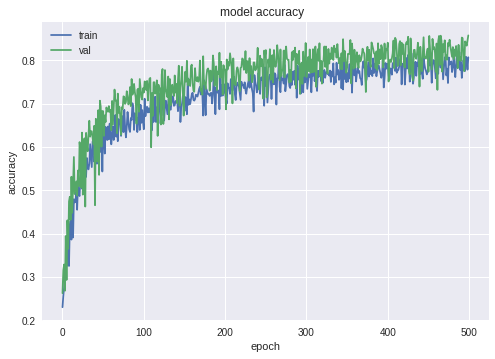

In [0]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'] )
plt.plot(history.history['val_categorical_accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

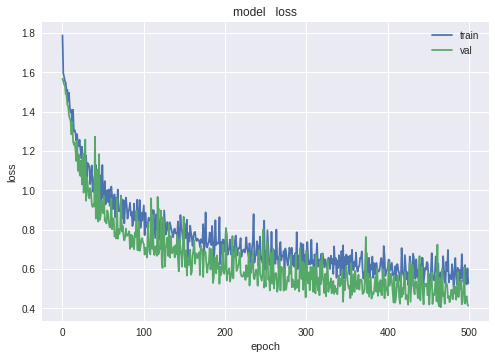

In [0]:
# summarize history for loss
plt.plot(history.history['loss'] )

plt.plot(history.history['val_loss'])
plt.title('model   loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()